# SPY Minute Bar Data — Exploration

First look at the data: what do we have, what does intraday activity look like,
and which days should we focus on for deeper analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('..')

from src.data_collection import load_bars, clean_bars, add_derived_columns, get_daily_summary

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['figure.dpi'] = 100

## Load and clean the data

In [2]:
bars = load_bars()
bars = clean_bars(bars)
bars = add_derived_columns(bars)

print(f"\nShape: {bars.shape}")
print(f"Columns: {list(bars.columns)}")
bars.head(10)

Loaded 54,374 bars
Date range: 2020-01-02 04:00:00 to 2020-04-01 19:59:00
Cleaned: removed 29,860 bars (54.9%)
Remaining: 24,514 bars

Shape: (24514, 14)
Columns: ['datetime', 'open', 'high', 'low', 'close', 'volume', 'date', 'time', 'returns', 'log_returns', 'bar_range', 'bar_range_pct', 'vwap_proxy', 'dollar_volume']


,datetime,open,high,low,close,volume,date,time,returns,log_returns,bar_range,bar_range_pct,vwap_proxy,dollar_volume
0,2020-01-02 09:30:00,323.5400,323.7400,323.5300,323.7200,883529,2020-01-02,09:30:00,NaN,NaN,0.2100,0.064871,323.663333,2.859659e+08
1,2020-01-02 09:31:00,323.7271,323.7271,323.4400,323.5200,281415,2020-01-02,09:31:00,-0.000618,-0.000618,0.2871,0.088743,323.562367,9.105530e+07
2,2020-01-02 09:32:00,323.5000,323.5850,323.4100,323.5214,201607,2020-01-02,09:32:00,0.000004,0.000004,0.1750,0.054092,323.505467,6.522097e+07
3,2020-01-02 09:33:00,323.5200,323.8300,323.5000,323.7700,246777,2020-01-02,09:33:00,0.000768,0.000768,0.3300,0.101924,323.700000,7.988171e+07
4,2020-01-02 09:34:00,323.7600,323.8600,323.6700,323.6800,192233,2020-01-02,09:34:00,-0.000278,-0.000278,0.1900,0.058700,323.736667,6.223287e+07
5,2020-01-02 09:35:00,323.6750,323.9800,323.6600,323.9300,422749,2020-01-02,09:35:00,0.000772,0.000772,0.3200,0.098787,323.856667,1.369101e+08
6,2020-01-02 09:36:00,323.9200,323.9750,323.8300,323.9200,266637,2020-01-02,09:36:00,-0.000031,-0.000031,0.1450,0.044764,323.908333,8.636595e+07
7,2020-01-02 09:37:00,323.9300,323.9600,323.7877,323.8200,207102,2020-01-02,09:37:00,-0.000309,-0.000309,0.1723,0.053209,323.855900,6.707120e+07
8,2020-01-02 09:38:00,323.8300,323.8700,323.6550,323.7400,202378,2020-01-02,09:38:00,-0.000247,-0.000247,0.2150,0.066411,323.755000,6.552089e+07
9,2020-01-02 09:39:00,323.7500,323.8700,323.7500,323.8500,169783,2020-01-02,09:39:00,0.000340,0.000340,0.1200,0.037054,323.823333,5.497970e+07


In [3]:
bars.describe()

,datetime,open,high,low,close,volume,returns,log_returns,bar_range,bar_range_pct,vwap_proxy,dollar_volume
count,24514,24514.000000,24514.000000,24514.000000,24514.000000,2.451400e+04,24513.000000,24513.000000,24514.000000,24514.000000,24514.000000,2.451400e+04
mean,2020-02-17 02:10:16.435506,304.194355,304.374361,304.023176,304.194999,3.389187e+05,-0.000010,-0.000011,0.351185,0.128565,304.197512,9.567993e+07
min,2020-01-02 09:30:00,218.435400,218.700000,218.260000,218.440000,5.915000e+03,-0.110877,-0.117520,0.010000,0.002997,218.546667,1.970188e+06
25%,2020-01-24 14:08:15,276.562500,276.902500,276.260000,276.550000,7.379300e+04,-0.000268,-0.000268,0.080000,0.024729,276.548333,2.433150e+07
50%,2020-02-18 12:16:30,323.390000,323.452500,323.340000,323.397500,1.996355e+05,0.000000,0.000000,0.190000,0.057538,323.400517,6.034711e+07
75%,2020-03-11 10:38:45,330.697500,330.760000,330.625000,330.697500,4.571870e+05,0.000244,0.000244,0.520000,0.189692,330.692500,1.259616e+08
max,2020-04-01 15:59:00,339.010000,339.080000,338.990000,339.010000,1.591813e+07,0.060419,0.058664,11.019100,4.466961,339.013333,3.850994e+09
std,NaN,34.761540,34.623323,34.893755,34.760984,4.367825e+05,0.001776,0.001801,0.418778,0.163796,34.758989,1.167936e+08


## Daily summary

Get a feel for how days differ — volume, range, returns.

In [4]:
summary = get_daily_summary(bars)
summary.head(10)

,date,num_bars,total_volume,total_dollar_vol,open_price,close_price,high,low,avg_bar_volume,avg_range_pct,day_range_pct,return_pct
0,2020-01-02,390,48217559,1.560368e+10,323.5400,324.84,324.85,322.530,123634.766667,0.024914,0.717067,0.401805
1,2020-01-03,390,58408809,1.885331e+10,321.1600,322.44,323.64,321.100,149766.176923,0.035840,0.790883,0.398555
2,2020-01-06,390,43105385,1.390267e+10,320.4900,323.67,323.73,320.360,110526.628205,0.024708,1.051515,0.992231
3,2020-01-07,390,33909984,1.095052e+10,323.0200,322.76,323.54,322.240,86948.676923,0.025977,0.402452,-0.080490
4,2020-01-08,390,56581814,1.836443e+10,322.9400,324.42,325.78,322.670,145081.574359,0.031578,0.963027,0.458289
5,2020-01-09,390,43365068,1.414731e+10,326.1600,326.62,326.73,325.520,111192.482051,0.025687,0.370984,0.141035
6,2020-01-10,390,44989039,1.468753e+10,327.2899,325.70,327.46,325.200,115356.510256,0.027060,0.690519,-0.485777
7,2020-01-13,390,36691541,1.200341e+10,326.3900,327.94,327.96,325.920,94080.874359,0.020971,0.625019,0.474892
8,2020-01-14,390,53797230,1.762289e+10,327.4700,327.43,328.62,326.844,137941.615385,0.032958,0.542340,-0.012215
9,2020-01-15,390,58544879,1.921808e+10,327.3500,328.17,329.02,327.260,150115.074359,0.028556,0.537651,0.250496


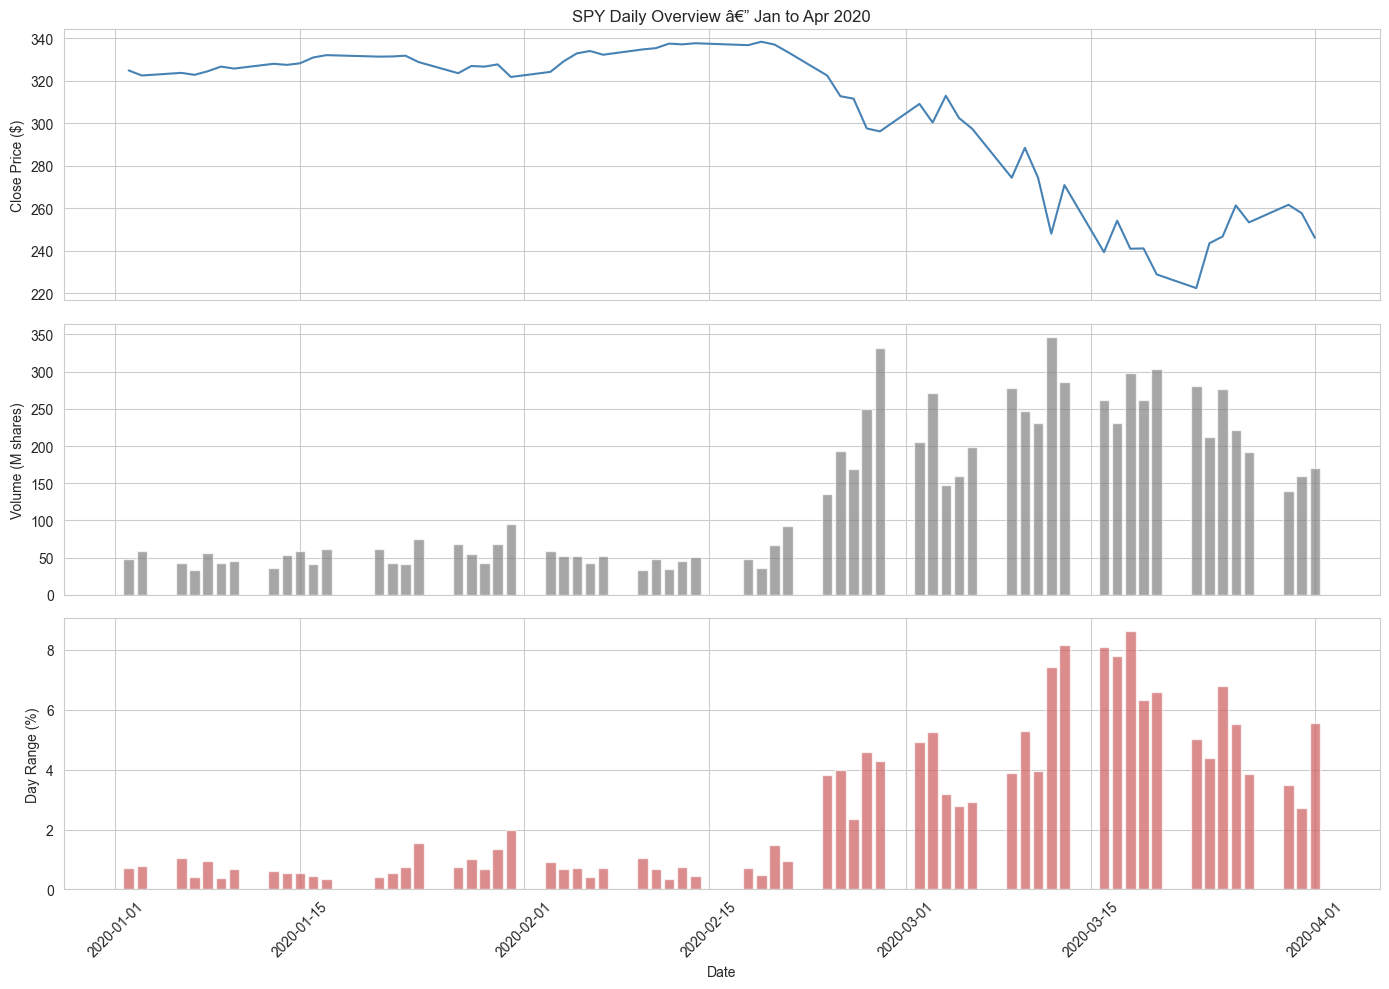

In [5]:
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# close price over time
axes[0].plot(summary['date'], summary['close_price'], color='steelblue', linewidth=1.5)
axes[0].set_ylabel('Close Price ($)')
axes[0].set_title('SPY Daily Overview — Jan to Apr 2020')

# daily volume
axes[1].bar(summary['date'], summary['total_volume'] / 1e6, color='gray', alpha=0.7)
axes[1].set_ylabel('Volume (M shares)')

# daily range
axes[2].bar(summary['date'], summary['day_range_pct'], color='indianred', alpha=0.7)
axes[2].set_ylabel('Day Range (%)')
axes[2].set_xlabel('Date')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Intraday volume profile

Classic U-shape pattern — high volume at open and close, quiet midday.
Let's see how this holds up across different regimes.

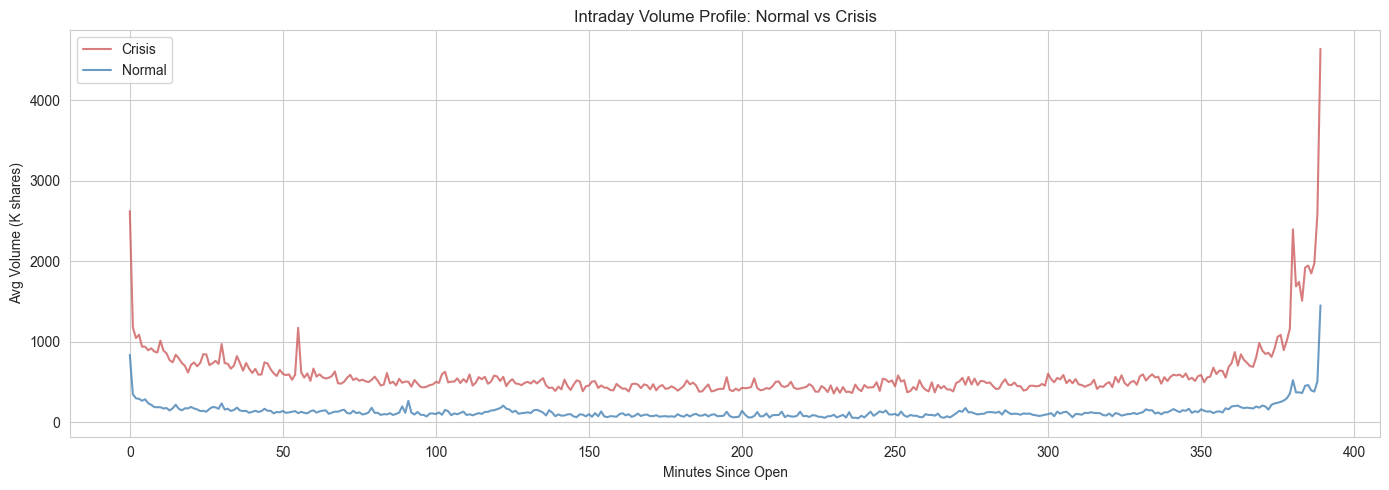

In [6]:
# split into pre-crash (Jan) and crash (late Feb - Mar) periods
bars['period'] = 'normal'
bars.loc[bars['date'] >= pd.Timestamp('2020-02-24').date(), 'period'] = 'crisis'

# average volume by minute of day
bars['minutes_since_open'] = (
    bars['datetime'].dt.hour * 60 + bars['datetime'].dt.minute - 570  # 570 = 9:30 in minutes
)

vol_profile = bars.groupby(['period', 'minutes_since_open'])['volume'].mean().reset_index()

fig, ax = plt.subplots(figsize=(14, 5))
for period, group in vol_profile.groupby('period'):
    color = 'indianred' if period == 'crisis' else 'steelblue'
    ax.plot(group['minutes_since_open'], group['volume'] / 1e3, 
            label=period.capitalize(), color=color, alpha=0.8)

ax.set_xlabel('Minutes Since Open')
ax.set_ylabel('Avg Volume (K shares)')
ax.set_title('Intraday Volume Profile: Normal vs Crisis')
ax.legend()
plt.tight_layout()
plt.show()

## Intraday volatility profile

Similar to volume — volatility (measured by bar range) should be higher
at open/close and spike during the crash period.

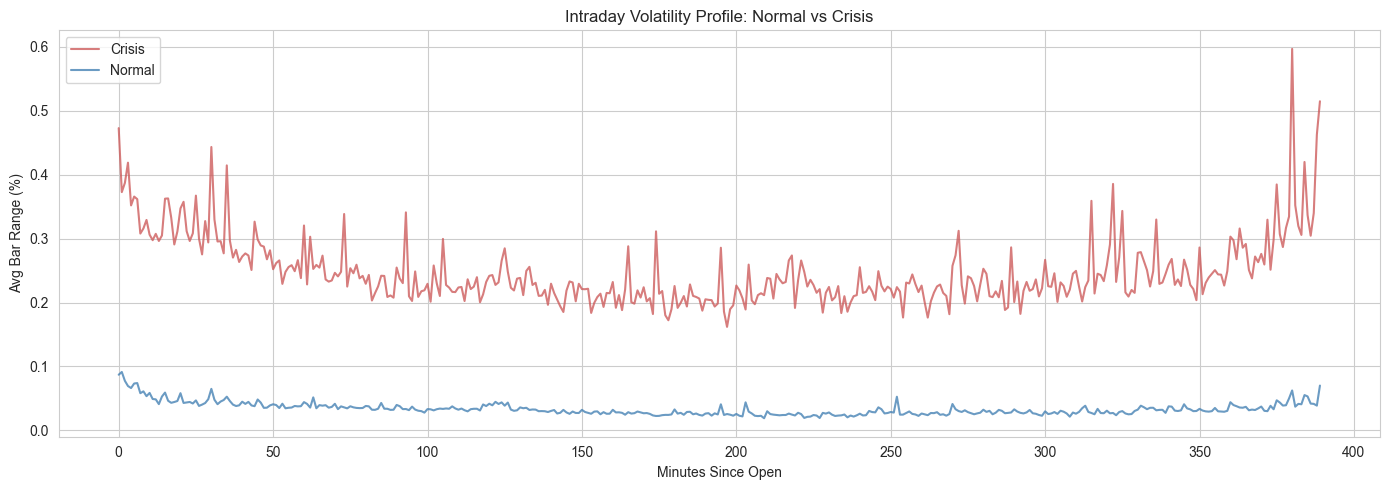

In [7]:
vol_profile_range = bars.groupby(['period', 'minutes_since_open'])['bar_range_pct'].mean().reset_index()

fig, ax = plt.subplots(figsize=(14, 5))
for period, group in vol_profile_range.groupby('period'):
    color = 'indianred' if period == 'crisis' else 'steelblue'
    ax.plot(group['minutes_since_open'], group['bar_range_pct'], 
            label=period.capitalize(), color=color, alpha=0.8)

ax.set_xlabel('Minutes Since Open')
ax.set_ylabel('Avg Bar Range (%)')
ax.set_title('Intraday Volatility Profile: Normal vs Crisis')
ax.legend()
plt.tight_layout()
plt.show()

## Return distribution

Compare the distribution of 1-minute returns across regimes.
Expect fatter tails during the crash.

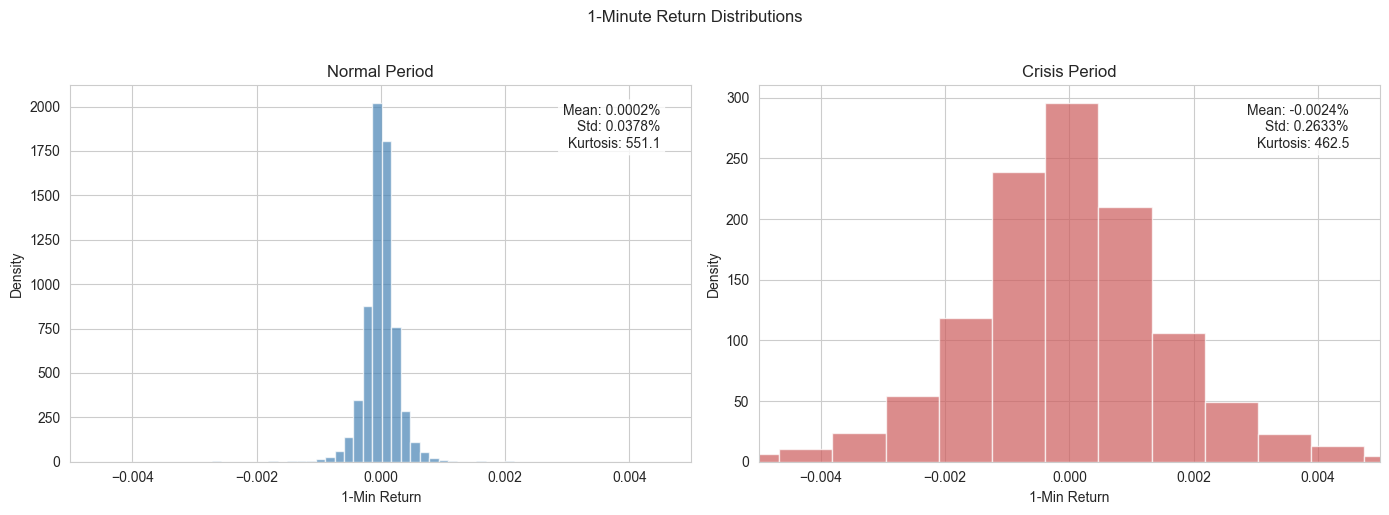

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i, period in enumerate(['normal', 'crisis']):
    subset = bars[bars['period'] == period]['returns'].dropna()
    color = 'steelblue' if period == 'normal' else 'indianred'
    
    axes[i].hist(subset, bins=200, color=color, alpha=0.7, density=True)
    axes[i].set_title(f'{period.capitalize()} Period')
    axes[i].set_xlabel('1-Min Return')
    axes[i].set_ylabel('Density')
    axes[i].set_xlim(-0.005, 0.005)
    
    # stats
    stats_text = f'Mean: {subset.mean()*100:.4f}%\nStd: {subset.std()*100:.4f}%\nKurtosis: {subset.kurtosis():.1f}'
    axes[i].text(0.95, 0.95, stats_text, transform=axes[i].transAxes,
                verticalalignment='top', horizontalalignment='right',
                fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle('1-Minute Return Distributions', y=1.02)
plt.tight_layout()
plt.show()

## Single-day deep dives

Look at a few individual days to understand intraday dynamics.
These are candidates for deeper microstructure analysis.

In [9]:
def plot_single_day(bars, date, title=None):
    """Plot price and volume for a single trading day."""
    day = bars[bars['date'] == date].copy()
    if len(day) == 0:
        print(f"No data for {date}")
        return
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 7), sharex=True,
                                    gridspec_kw={'height_ratios': [2, 1]})
    
    if title is None:
        ret = (day['close'].iloc[-1] / day['open'].iloc[0] - 1) * 100
        title = f'SPY — {date} (Return: {ret:+.2f}%)'
    
    # price
    ax1.plot(day['datetime'], day['close'], color='steelblue', linewidth=1)
    ax1.fill_between(day['datetime'], day['low'], day['high'], alpha=0.15, color='steelblue')
    ax1.set_ylabel('Price ($)')
    ax1.set_title(title)
    
    # volume
    ax2.bar(day['datetime'], day['volume'] / 1e3, width=0.0005, color='gray', alpha=0.6)
    ax2.set_ylabel('Volume (K)')
    ax2.set_xlabel('Time')
    
    plt.tight_layout()
    plt.show()
    
    # print some stats
    print(f"  Total volume: {day['volume'].sum():,.0f}")
    print(f"  Range: ${day['low'].min():.2f} - ${day['high'].max():.2f} ({(day['high'].max()-day['low'].min())/day['open'].iloc[0]*100:.2f}%)")
    print(f"  Avg bar volume: {day['volume'].mean():,.0f}")
    print(f"  Median bar range: {day['bar_range_pct'].median():.4f}%")

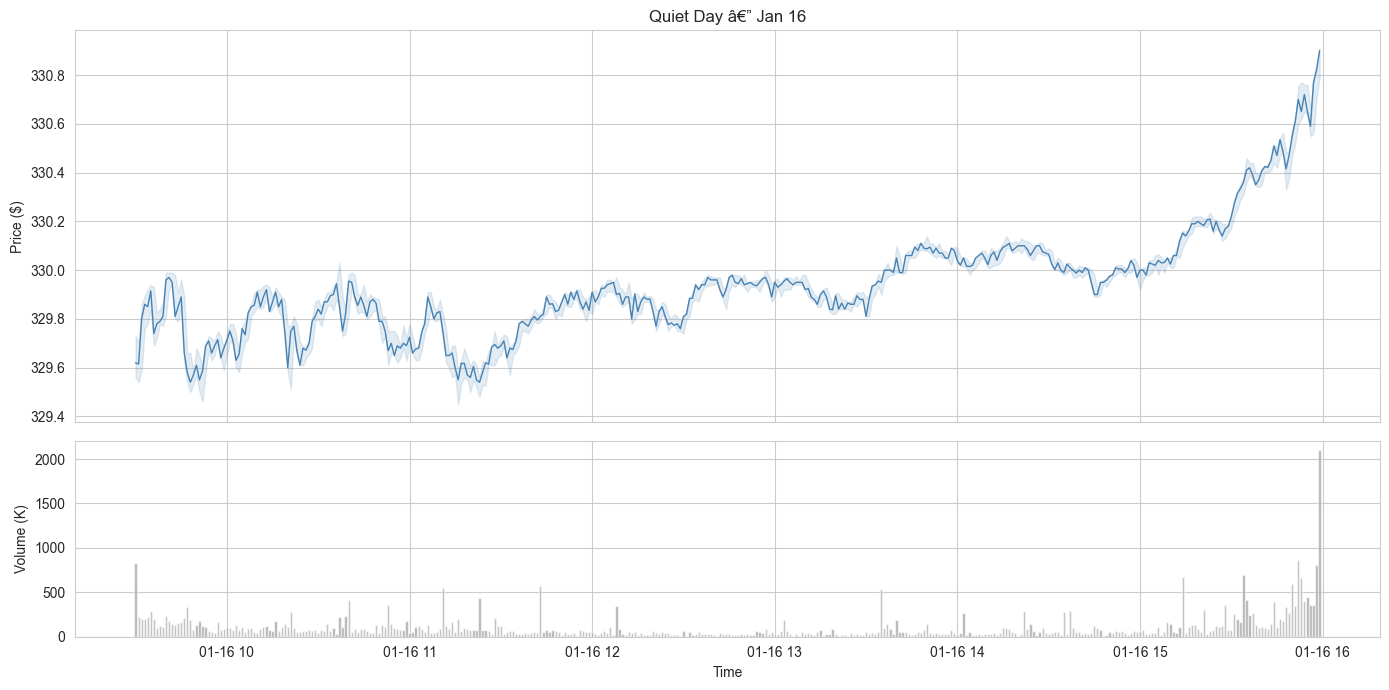

  Total volume: 41,650,723
  Range: $329.45 - $330.91 (0.44%)
  Avg bar volume: 106,797
  Median bar range: 0.0182%


In [10]:
import datetime

# quiet day
plot_single_day(bars, datetime.date(2020, 1, 16), 'Quiet Day — Jan 16')

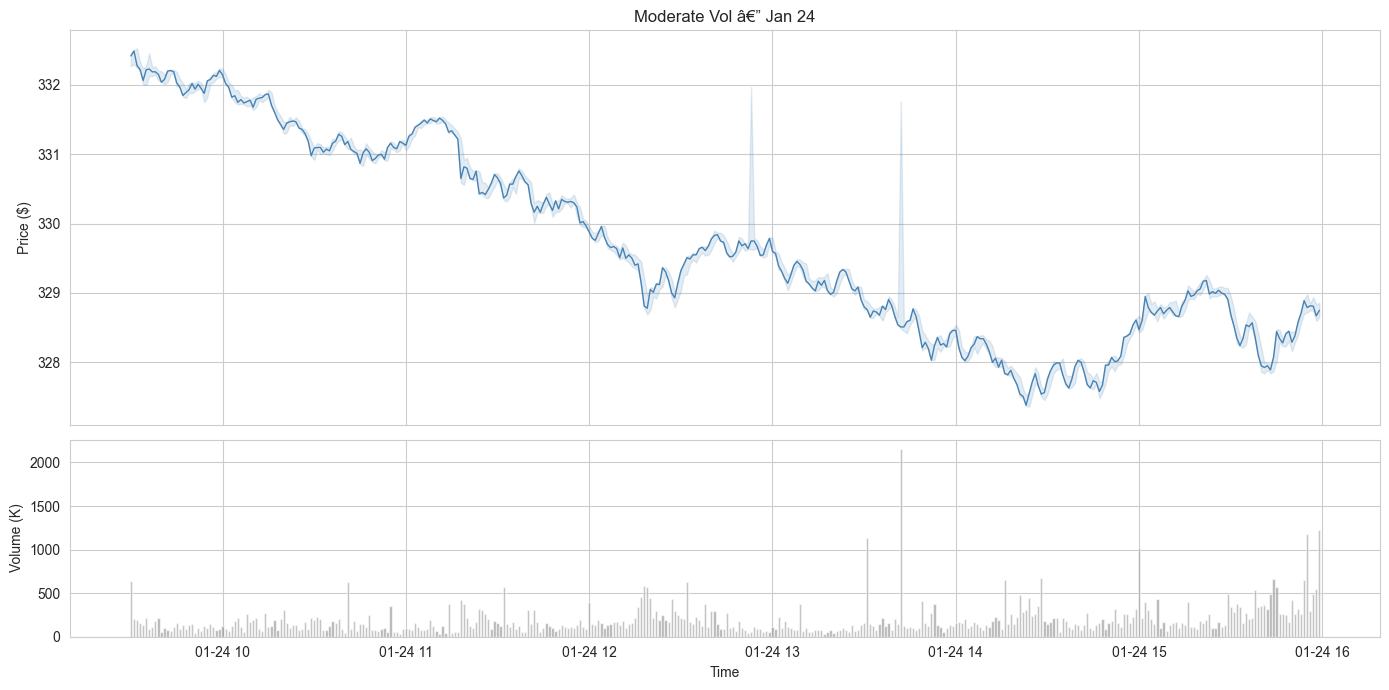

  Total volume: 75,281,306
  Range: $327.36 - $332.53 (1.56%)
  Avg bar volume: 193,029
  Median bar range: 0.0441%


In [11]:
# moderate volatility
plot_single_day(bars, datetime.date(2020, 1, 24), 'Moderate Vol — Jan 24')

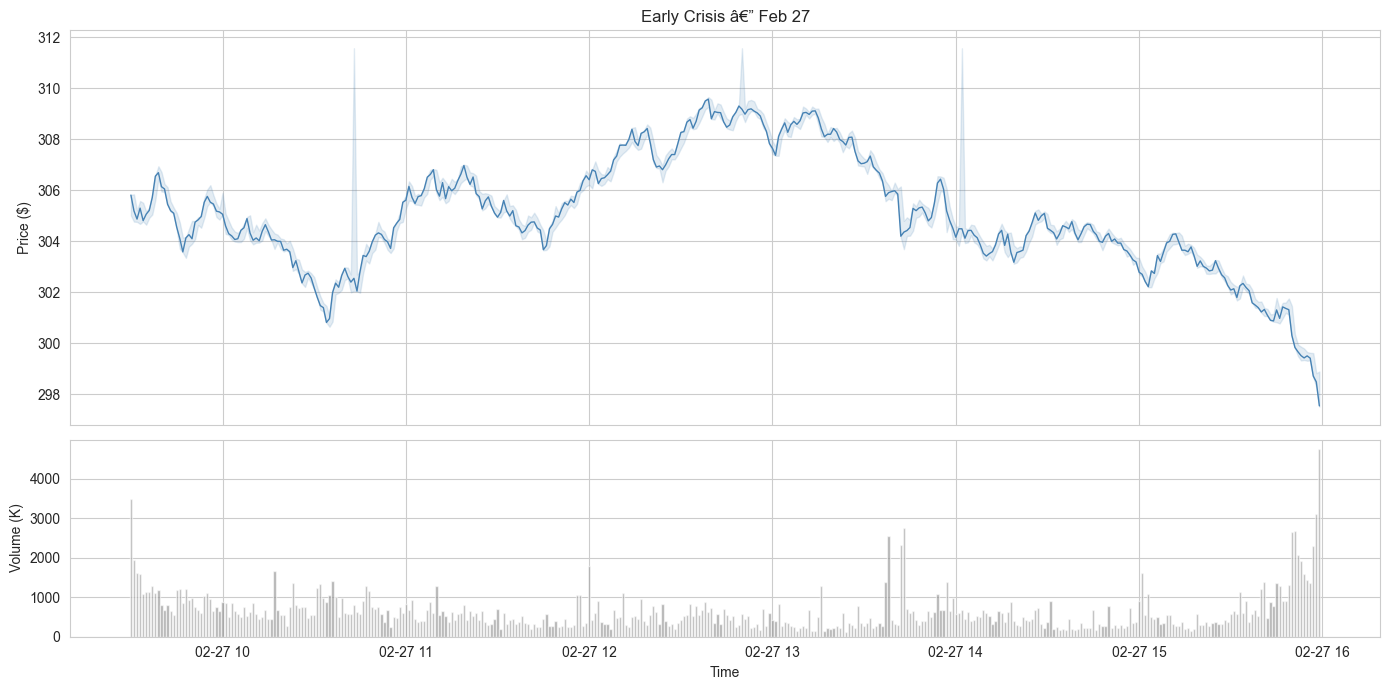

  Total volume: 249,706,794
  Range: $297.52 - $311.56 (4.60%)
  Avg bar volume: 640,274
  Median bar range: 0.1581%


In [12]:
# early crisis
plot_single_day(bars, datetime.date(2020, 2, 27), 'Early Crisis — Feb 27')

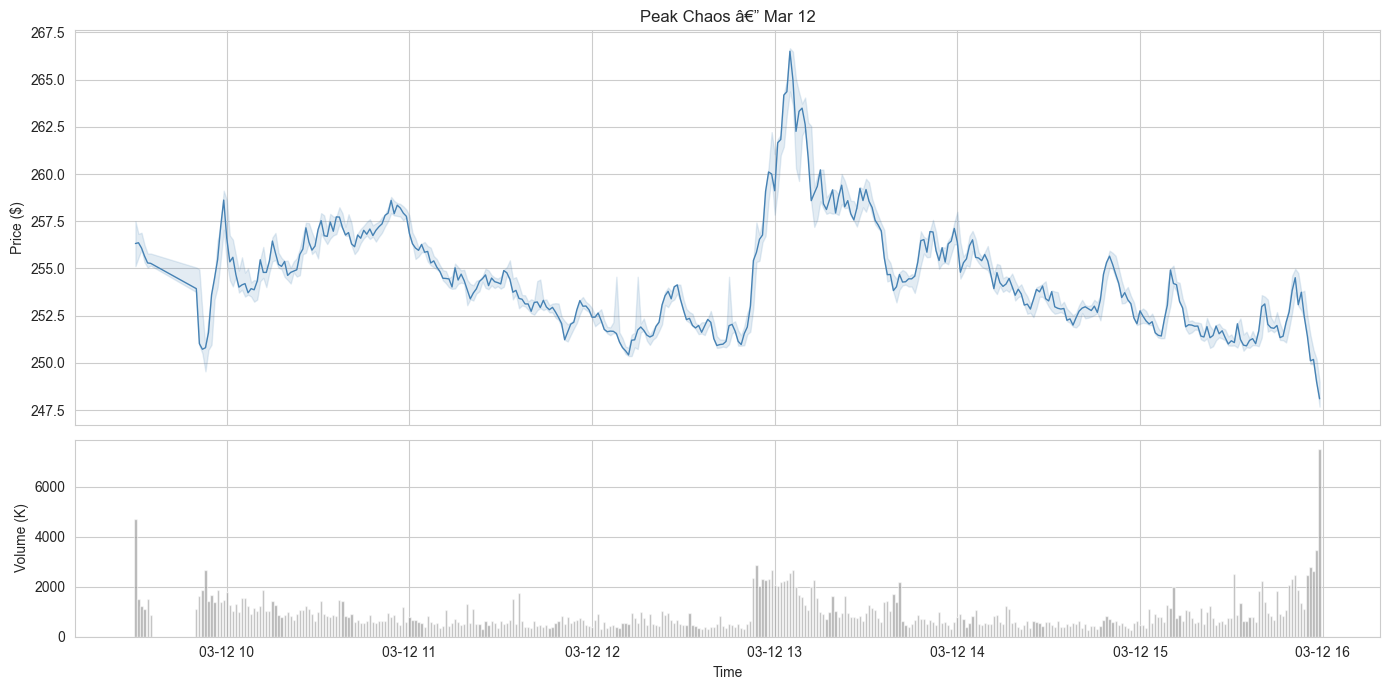

  Total volume: 346,670,590
  Range: $247.68 - $266.66 (7.41%)
  Avg bar volume: 921,996
  Median bar range: 0.3359%


In [13]:
# peak chaos
plot_single_day(bars, datetime.date(2020, 3, 12), 'Peak Chaos — Mar 12')

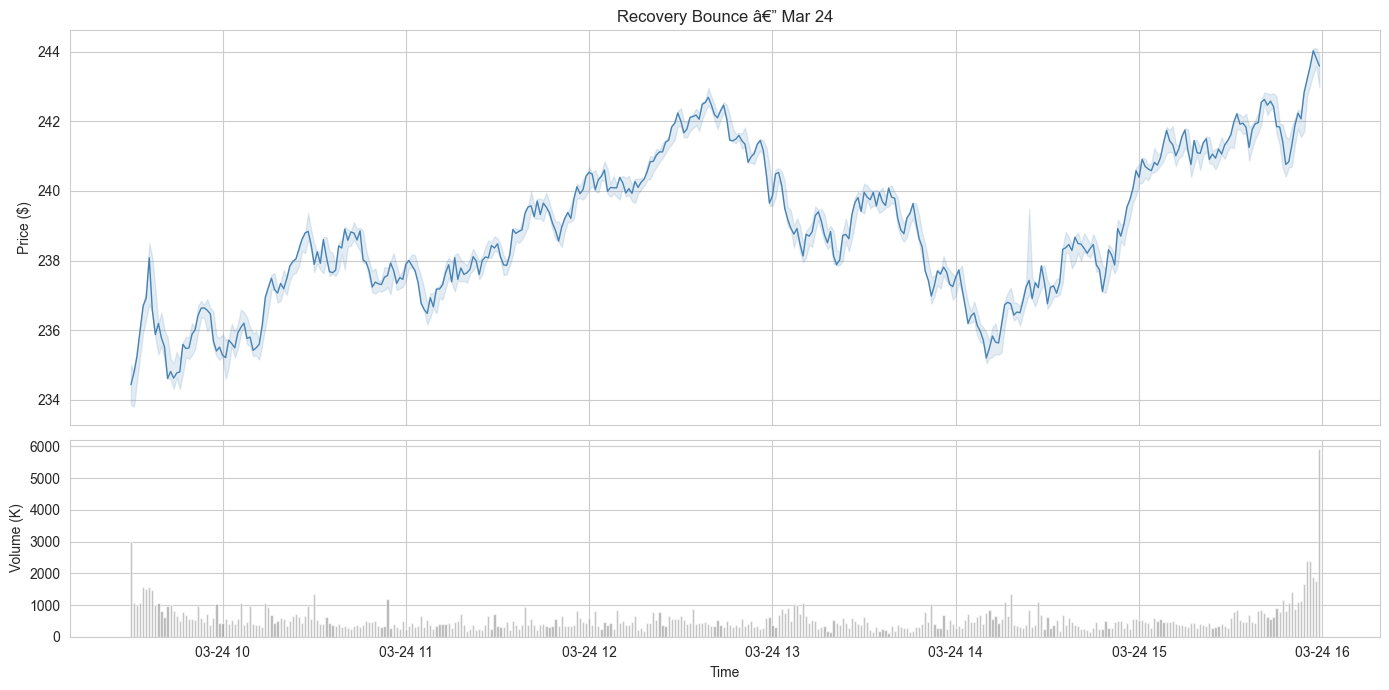

  Total volume: 211,595,249
  Range: $233.80 - $244.10 (4.39%)
  Avg bar volume: 542,552
  Median bar range: 0.2315%


In [14]:
# recovery bounce
plot_single_day(bars, datetime.date(2020, 3, 24), 'Recovery Bounce — Mar 24')

## Volume-return relationship

Do big moves come with big volume? (Spoiler: yes, but it's worth seeing.)

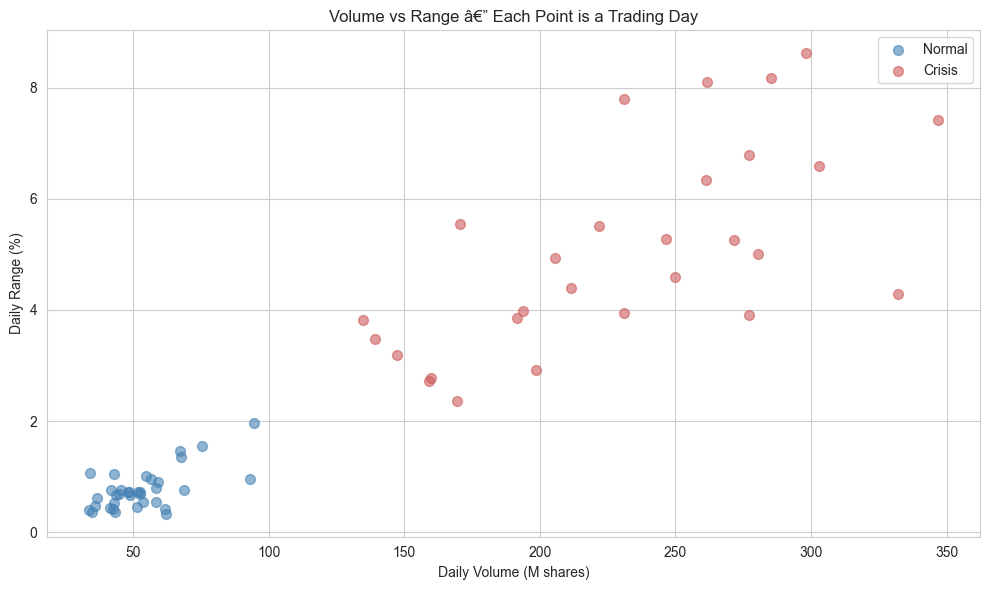

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))

colors = {'normal': 'steelblue', 'crisis': 'indianred'}
for period in ['normal', 'crisis']:
    mask = summary['date'].isin(
        bars[bars['period'] == period]['date'].unique()
    )
    subset = summary[mask]
    ax.scatter(subset['total_volume'] / 1e6, subset['day_range_pct'],
              color=colors[period], alpha=0.6, label=period.capitalize(), s=50)

ax.set_xlabel('Daily Volume (M shares)')
ax.set_ylabel('Daily Range (%)')
ax.set_title('Volume vs Range — Each Point is a Trading Day')
ax.legend()
plt.tight_layout()
plt.show()

## Selected analysis days

Based on the exploration, these 5 days give good coverage across regimes:

| Day | Date | Character | Why |
|-----|------|-----------|-----|
| 1 | Jan 16 | Quiet | Low vol, tight range — baseline for "normal" microstructure |
| 2 | Jan 24 | Moderate | Slightly elevated vol, decent range — typical active day |
| 3 | Feb 27 | Early crisis | First big selloff, 4.6% range — transition to panic |
| 4 | Mar 12 | Peak chaos | 7.4% range, 347M shares — extreme stress |
| 5 | Mar 24 | Recovery | Big bounce, 4.4% range — how does the book recover? |

In [16]:
import datetime

analysis_dates = [
    datetime.date(2020, 1, 16),
    datetime.date(2020, 1, 24),
    datetime.date(2020, 2, 27),
    datetime.date(2020, 3, 12),
    datetime.date(2020, 3, 24),
]

selected = summary[summary['date'].isin(analysis_dates)]
selected[['date', 'num_bars', 'total_volume', 'open_price', 'close_price', 
          'day_range_pct', 'return_pct', 'avg_bar_volume']].round(2)

,date,num_bars,total_volume,open_price,close_price,day_range_pct,return_pct,avg_bar_volume
10,2020-01-16,390,41650723,329.70,330.90,0.44,0.36,106796.73
15,2020-01-24,390,75281306,332.44,328.75,1.56,-1.11,193028.99
38,2020-02-27,390,249706794,305.46,297.55,4.60,-2.59,640273.83
48,2020-03-12,376,346670590,256.00,248.10,7.41,-3.09,921996.25
56,2020-03-24,390,211595249,234.42,243.59,4.39,3.91,542551.92
